# Diamond Price Modelling

 **What are diamonds ?**

> Diamond is a solid form of the element carbon with its atoms arranged in a crystal structure called diamond cubic.
The most familiar uses of diamonds today are as gemstones used for adornment, and as industrial abrasives for cutting hard materials.



 **In this notebook, we will try to build a model to predict the prices of diamonds based on various features of diamond  like carat weight, cut quality ,etc.**
 
*Dataset used in this notebook has been taken from [KAGGLE](https://www.kaggle.com/competitions/shai-ml/data)*

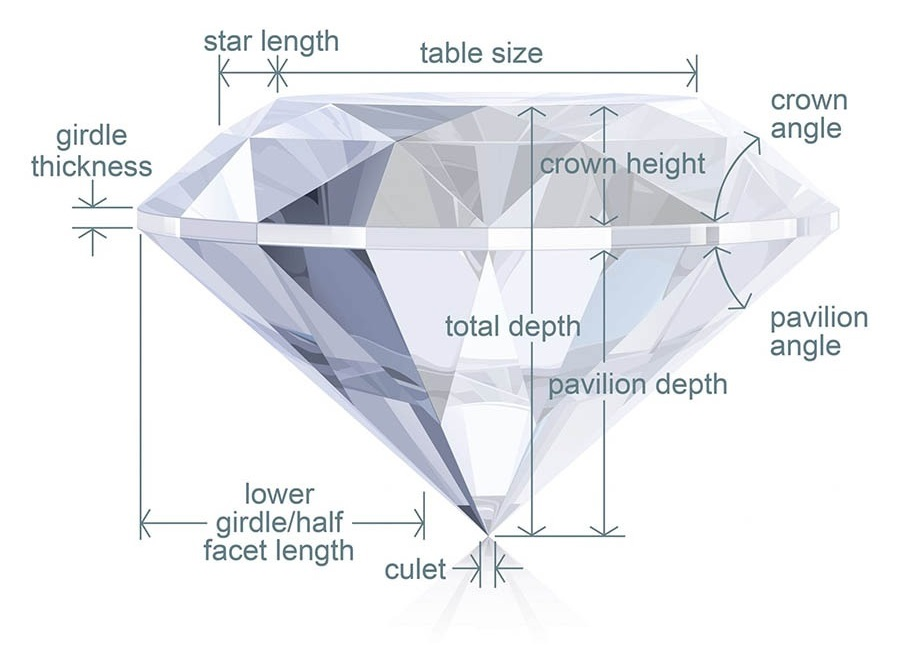

### Features of the Dataset

- **Carat** weight of the diamond
- **cut** Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal - - - **color** Color of the diamond, with D being the best and J the worst
- **clarity** How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
- **depth** The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
- **table** The width of the diamond's table expressed as a percentage of its average diameter
- **price** the price of the diamond
- **x** length mm
- **y** width mm
- **z** depth mm

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

***
# 1- Get the Data
***

In [505]:
# Read the Data (train - test )
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submit = pd.read_csv('/content/sample_submission.csv')

***
# 2- Prepare the data
***

## A- Data Cleaning

In [506]:
# Drop unnecessary Column
train.drop('Unnamed: 0',inplace=True,axis=1)
test.drop('Unnamed: 0',inplace=True,axis=1)

- Displays the duplicates.

In [507]:
# Check the duplicates
train.duplicated().sum() , test.duplicated().sum()

(127, 60)

- Drop Duplicates in train-data

In [508]:
# Drop Duplicates
train.drop_duplicates(inplace=True)

- Displays the missing values per column.

In [509]:
# Check NaNs
train.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [510]:
# Check NaNs
test.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

- Check if there any zeros in dataframe.

In [511]:
(train == 0).sum(axis=0)

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
price       0
x           6
y           5
z          16
dtype: int64

In [512]:
(test == 0).sum(axis=0)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          1
y          1
z          3
dtype: int64

Zeros may sometimes be missing values so we need to take a closer look at them

In [513]:
# #replace zeros with NaNs
# train.replace(0,np.nan,inplace=True)
# test.replace(0,np.nan,inplace=True)

after replacing zeros we will deal with the nans

## B- Handling Outliers

In [514]:
train = train[train['x'] < 9.2]
train = train[train['y'] < 30]
train = train[train['z'] < 30]
train = train[(train['table'] < 75) & (train['table'] > 45)]
train = train[(train['depth'] < 75) & (train['depth'] > 45)]

train.shape

(42872, 10)

we have set ranges to features ['table' ,'depth' ,'x' ,'y' ,'z'] to deal with the outlier to enhance the model RMSE

In [515]:
train = (train[train.carat < 3])

diamonds that weight is bigger than 3 are small percentage (0.07% of the data ) so we remove them

## C- Handling Text and Categorical Attributes

In [516]:
num_attribs = list(train.dtypes[train.dtypes == 'float64'].index)
categorical_feats = list(train.dtypes[train.dtypes == 'object'].index)

In [517]:
#Changing the the categorical features using OrdinalEncoder()
encoder = OrdinalEncoder()
diamond_cat_encoded = encoder.fit_transform(train[categorical_feats])

diamond_cat_encoded[:10]

array([[3., 1., 2.],
       [3., 5., 5.],
       [1., 6., 3.],
       [4., 6., 7.],
       [4., 5., 6.],
       [0., 1., 5.],
       [1., 6., 2.],
       [3., 2., 2.],
       [2., 6., 3.],
       [3., 1., 3.]])

In [518]:
encoder.categories_

[array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object),
 array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object),
 array(['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'],
       dtype=object)]

- in ordinal encoder the ML algorithms will assume that two nearby values are more similar it will help me but it didn't convert in order as we see above so i decided to use OneHotEncoder, when i use it the model consume more time and power as the onehotencoder increase the number of features to the model.
- i decided to do ordinal encoder but manually so i create cat_enc to do this as we will see.

In [519]:
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
2,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
3,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
4,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


In [520]:
# function to do ordinal encoder to categorical features
def cat_enc(data):
  cat_to_enc = {'cut' : ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
              'color' : ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
              'clarity' : ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}
  for col,cat in cat_to_enc.items():
    enc_dict = {v:i for i,v in enumerate(cat)}
    data[col].replace(enc_dict,inplace=True)
  return data

In [521]:
train = cat_enc(train)
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
1,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
2,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75
3,0.24,2,6,5,62.8,57.0,336,3.94,3.96,2.48
4,0.24,2,5,6,62.3,57.0,336,3.95,3.98,2.47


In [522]:
test = cat_enc(test)
test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,4,1,1,61.5,55.0,3.95,3.98,2.43
1,0.23,1,1,4,56.9,65.0,4.05,4.07,2.31
2,0.26,2,4,2,61.9,55.0,4.07,4.11,2.53
3,0.23,2,4,4,59.4,61.0,4.00,4.05,2.39
4,0.23,4,6,4,62.8,56.0,3.93,3.90,2.46


## D- Attribute Combinations

In [523]:
train['volume'] = train['x'] * train['y'] * train['z']
test['volume'] = test['x'] * test['y'] * test['z']

the column volume which is the product of (x ,y ,z) add feature correlated to the label (price)

## E- Feature Scaling

In [524]:
sc_daimonds = StandardScaler()
train[num_attribs] = sc_daimonds.fit_transform(train[num_attribs])
test[num_attribs] = sc_daimonds.transform(test[num_attribs])

In [525]:
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,-1.230800,3,1,2,-1.372663,1.602140,326,-1.625936,-1.684507,-1.752421,34.505856
1,-1.062367,3,5,3,0.463061,0.252713,334,-1.350689,-1.335682,-1.293327,46.724580
2,-1.020258,1,6,1,1.098503,0.252713,335,-1.226384,-1.228352,-1.121167,51.917250
3,-1.167638,2,6,5,0.745480,-0.197097,336,-1.581541,-1.577176,-1.508527,38.693952
4,-1.167638,2,5,6,0.392456,-0.197097,336,-1.572662,-1.559288,-1.522874,38.830870


In [526]:
test.head()

,carat,cut,color,clarity,depth,table,x,y,z,volume
0,-1.188692,4,1,1,-0.172382,-1.096715,-1.572662,-1.559288,-1.580261,38.202030
1,-1.188692,1,1,4,-3.420201,3.401377,-1.483873,-1.478790,-1.752421,38.076885
2,-1.125529,2,4,2,0.110037,-1.096715,-1.466115,-1.443013,-1.436794,42.321081
3,-1.188692,2,4,4,-1.655082,1.602140,-1.528267,-1.496678,-1.637648,38.718000
4,-1.188692,4,6,4,0.745480,-0.646906,-1.590420,-1.630842,-1.537221,37.704420


## Correlation After Preparation

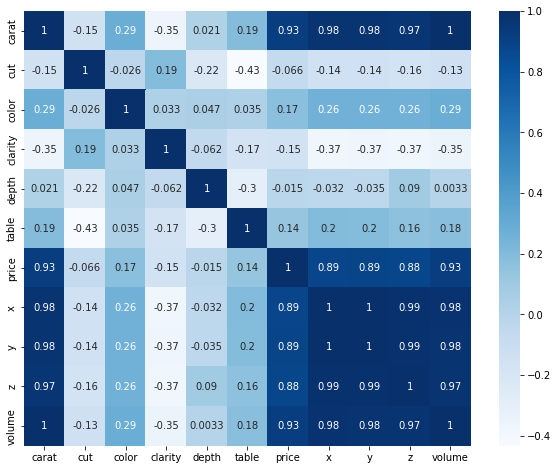

In [527]:
corr_matrix = train.corr()

plt.subplots(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "Blues")
plt.show()

- it's clear that Volume is highly correlated to price

***
# 3- Create a Test Set and Train Set
***

In [528]:
# CODE HERE
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

In [529]:
# CODE HERE
X_train = train_set.drop("price", axis=1)
y_train = train_set["price"]
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"]

***
# 4- Modeling
***



5.1- **Linear regression**



In [530]:
#Training Multiple Linear Regression to the Training set
#linear regression model
lin_reg= LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [531]:
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [532]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 1151.9720079727715, Val RMSE = 1152.1108140746096




5.2- **DecisionTreeRegressor**



In [533]:
#DecisionTreeRegressor model
tree_reg = DecisionTreeRegressor(max_depth=11, min_samples_split=5, min_samples_leaf=1, random_state=20)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=11, min_samples_split=5, random_state=20)

In [534]:
y_pred_train = tree_reg.predict(X_train)
y_pred_test = tree_reg.predict(X_test)

In [535]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 488.73421806991826, Val RMSE = 646.5470306944572


5.3- **RandomForestRegressor**

In [562]:
#RandomForestRegressor Model
forest_reg = RandomForestRegressor(n_estimators=50, max_depth=16, max_features=8, min_samples_split=2, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [563]:
y_pred_train = forest_reg.predict(X_train)
y_pred_test = forest_reg.predict(X_test)

In [564]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 205.5963486317302, Val RMSE = 548.4810125262079




5.4- **LGBMRegressor**



In [565]:
lgbm_model = LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_depth=14, n_estimators=3000,
              num_leaves=20)

In [566]:
y_pred_train = lgbm_model.predict(X_train)
y_pred_test = lgbm_model.predict(X_test)

In [567]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 430.41806065682005, Val RMSE = 523.4225854900645




5.5- **XGBRegressor**



In [542]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

[15:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [543]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [544]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 604.1465907886102, Val RMSE = 612.9870532343011




5.6- **GradientBoostingRegressor**



In [480]:
gradient_model = GradientBoostingRegressor()
gradient_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [481]:
y_pred_train = gradient_model.predict(X_train)
y_pred_test = gradient_model.predict(X_test)

In [482]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 597.133432073693, Val RMSE = 614.5327369344178




5.7- **StackingRegressor**



In [489]:
estimators = [('dt1', DecisionTreeRegressor())]
stack_model = StackingRegressor(estimators=estimators, final_estimator=DecisionTreeRegressor())

In [490]:
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('dt1', DecisionTreeRegressor())],
                  final_estimator=DecisionTreeRegressor())

In [491]:
y_pred_train = stack_model.predict(X_train)#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')
y_pred_test = stack_model.predict(X_test)

Train RMSE = 613.614291793884, Val RMSE = 778.6103347476328




5.8- **VotingRegressor**



In [572]:
estimators = [('lgbm1', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('lgbm2', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('lgbm3', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('rf', RandomForestRegressor(n_estimators=50, max_depth=16, max_features=8, min_samples_split=2, random_state=42))]

voting_model = VotingRegressor(estimators=estimators)

In [573]:
voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('lgbm1',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('lgbm2',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('lgbm3',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('rf',
                             RandomForestRegressor(max_depth=16, max_features=8,
                                                   n_estimators=50,
                                                   random_state=42))])

In [574]:
y_pred_train = voting_model.predict(X_train)
y_pred_test = voting_model.predict(X_test)

In [575]:
#claculating error
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE = {rmse_train}, Val RMSE = {rmse_val}')

Train RMSE = 380.606062265163, Val RMSE = 518.061627722972


# 5. Fine Tuning the Model

as we can see that the highest two defult models is RandomForest and LGBMRegressor so we trying to fine tuning them using Grid Search

- RandomForest

In [549]:
param_grid = [
 {'n_estimators': [10, 20, 30,40,50], 'max_depth': [2, 4, 6, 8,10,12,14,16],'min_samples_split' : [1,2,3] ,
  'max_features' : [2,4,6,8],'random_state' : [42]},
 ]

In [550]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
                          'max_features': [2, 4, 6, 8],
                          'min_samples_split': [1, 2, 3],
                          'n_estimators': [10, 20, 30, 40, 50],
                          'random_state': [42]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [551]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 8,
 'min_samples_split': 2,
 'n_estimators': 50,
 'random_state': 42}

- LGBMRegressor

In [552]:
param_grid = [
 {'num_leaves': [14 ,18, 20], 'max_depth': [ 10, 12, 14],'learning_rate' : [0.01, 0.05, 0.01] ,
  'n_estimators' : [1000,2000,3000]},
 ]

In [553]:
lgbm_model = LGBMRegressor()
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.01],
                          'max_depth': [10, 12, 14],
                          'n_estimators': [1000, 2000, 3000],
                          'num_leaves': [14, 18, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [554]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 14,
 'n_estimators': 3000,
 'num_leaves': 20}

# 6. Best-Models

- use the best models to train on the full-train-data then predict the test

In [576]:
X_train = train.drop("price", axis=1)
y_train = train["price"]
X_test = test



1- RandomForestRegressor



In [577]:
#RandomForestRegressor Model
forest_reg = RandomForestRegressor(n_estimators=50, max_depth=16, max_features=8, min_samples_split=2, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, max_features=8, n_estimators=50,
                      random_state=42)

In [578]:
random_y_pred_test = tree_reg.predict(X_test)

2- LGBMRegressor

In [579]:
#LGBMRegressor Model
lgbm_model = LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_depth=14, n_estimators=3000,
              num_leaves=20)

In [580]:
lgbm_y_pred_test = forest_reg.predict(X_test)



3- VotingRegressor



In [581]:
estimators = [('lgbm1', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('lgbm2', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('lgbm3', LGBMRegressor(num_leaves=20, max_depth=14, learning_rate=0.01, n_estimators=3000)),
              ('rf', RandomForestRegressor(n_estimators=50, max_depth=16, max_features=8, min_samples_split=2, random_state=42))]

voting_model = VotingRegressor(estimators=estimators)

In [582]:
voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('lgbm1',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('lgbm2',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('lgbm3',
                             LGBMRegressor(learning_rate=0.01, max_depth=14,
                                           n_estimators=3000, num_leaves=20)),
                            ('rf',
                             RandomForestRegressor(max_depth=16, max_features=8,
                                                   n_estimators=50,
                                                   random_state=42))])

In [583]:
voting_y_pred_test = voting_model.predict(X_test)

# 7. submission 

In [584]:
#upload prediction prices into sample submition 
submit['price'] = random_y_pred_test

In [585]:
submit.to_csv("random_y_pred_test.csv",index=False)

In [586]:
#upload prediction prices into sample submition 
submit['price'] = lgbm_y_pred_test

In [587]:
submit.to_csv("lgbm_y_pred_test.csv",index=False)

In [588]:
#upload prediction prices into sample submition 
submit['price'] = voting_y_pred_test

In [589]:
submit.to_csv("voting_y_pred_test.csv",index=False)